In [1]:
import andes
andes.config_logger(30)

import csv
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
case1 = 'ieee14_htb.xlsx'
case2 = 'pjm5_htb.xlsx'
case3 = 'npcc_htb.xlsx'

ss = andes.load(case1,
                no_output=True,
                default_config=False,
                setup=False)

# Note: case1 using 'GENROU_2', case2 using '2'
# ss.add("Toggler", dict(model='SynGen', dev="2", t=5.0))
ss.setup()

ss.TDS.config.no_tqdm = 1
ss.TDS.config.criteria = 0

ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0

ss.PFlow.run()

Generating code for 1 models on 8 processes.


True

In [3]:
tf = 0.1  # first time end_time of LTB
ss.TDS.config.tf = tf
ss.TDS.run()

t_step = 0.033  # step time
t_total = 10  # total time

pq_idx = 'PQ_1'  # load represents for HTB
bus_idx = ss.PQ.get(idx=pq_idx, src='bus', attr='v')  # load bus
a0 = ss.Bus.get(idx=bus_idx, src='a', attr='v')       # initial bus angle

k = 2 * np.pi * ss.config.freq # constant to calculate bus angle
start_time = time.time()  # clock time of LTB

tf0 = tf
def run_ltb(tf=tf, t_step=t_step, t_total=t_total):
    total_iter = 0
    lose_iter = 0
    data_in = False
    a_list = [] # DEBUG
    t_list = [] # DEBUG
    tsiml = [] # DEBUG
    tiol = [] # DEBUG
    while tf <= t_total:
        tf += t_step
        if data_in:
            # --- set data in LTB ---
            # ss.PQ.set(value=p_inj, idx=pq_idx, src='Ppf', attr='v')
            # ss.PQ.set(value=q_inj, idx=pq_idx, src='Qpf', attr='v')
            data_in = False
        tf2 = time.time()
        ss.TDS.config.tf = tf
        ss.TDS.run()
        t_sim = time.time() - tf2
        if t_sim > tf:
            lose_iter += 1
        else:
            pass
        # --- read data from HTB ---
        # the data read from HTB is written in a CSV file named 'rdata.csv'
        tf1 = time.time()
        data_read()
        f = open("rdata.csv", newline='')
        csv_reader = csv.reader(f)
        [i_read, a_read, time_stamp_read] = [float(i) for i in next(csv_reader)]
        data_in = True
        # --- send data to HTB ---
        a_period = k * ss.BusFreq.f.v[0] * tf  # Make sure `BusFreq` is connected to the load bus
        a_send = ss.Bus.get(idx=bus_idx, src='a', attr='v') - a0 + a_period
        a_send = np.mod(a_send, (2*np.pi))  # wave angle
        v_bus = ss.Bus.get(idx=bus_idx, src='v', attr='v')  # RMS
        sdata = [v_bus, a_send, tf]  # voltage, angle, time
        scsv = open("sdata.csv", "w")
        writer = csv.writer(open("sdata.csv", "w"))
        writer.writerow(sdata)
        scsv.close()
        # the data send to HTB is written in a CSV file named 'sdata.csv'
        data_send()
        t_io = time.time() - tf1
        # --- update power injection ---
        p_inj = v_bus * i_read * np.cos(a_send - a_read)
        q_inj = v_bus * i_read * np.sin(a_send - a_read)
        #  --- DEBUG --- can be deleted later
        a_list.append(sdata[1])
        t_list.append(sdata[2])
        tsiml.append(t_sim)
        tiol.append(t_io)
        total_iter += 1
        print(tf)

    print(f"Iter: total={total_iter}, lose={lose_iter}")
    print(r"loss rate=%.2f" %((lose_iter / total_iter)*100),"%")
    print(p_inj, q_inj)
    return a_list, t_list, tsiml, tiol

def data_read():
    pass

def data_send():
    pass

a_list, t_list, tsim, tio = run_ltb()

0.133
0.166
0.199
0.232
0.265
0.29800000000000004
0.33100000000000007
0.3640000000000001
0.39700000000000013
0.43000000000000016
0.4630000000000002
0.4960000000000002
0.5290000000000002
0.5620000000000003
0.5950000000000003
0.6280000000000003
0.6610000000000004
0.6940000000000004
0.7270000000000004
0.7600000000000005
0.7930000000000005
0.8260000000000005
0.8590000000000005
0.8920000000000006
0.9250000000000006
0.9580000000000006
0.9910000000000007
1.0240000000000007
1.0570000000000006
1.0900000000000005
1.1230000000000004
1.1560000000000004
1.1890000000000003
1.2220000000000002
1.2550000000000001
1.288
1.321
1.3539999999999999
1.3869999999999998
1.4199999999999997
1.4529999999999996
1.4859999999999995
1.5189999999999995
1.5519999999999994
1.5849999999999993
1.6179999999999992
1.6509999999999991
1.683999999999999
1.716999999999999
1.749999999999999
1.7829999999999988
1.8159999999999987
1.8489999999999986
1.8819999999999986
1.9149999999999985
1.9479999999999984
1.9809999999999983
2.01399

In [4]:
res = pd.DataFrame({"tsim": tsim, "tio": tio})
res['tsim'] *= 1000
res['tio'] *= 1000
res[res['tsim'] >= 33]

,tsim,tio


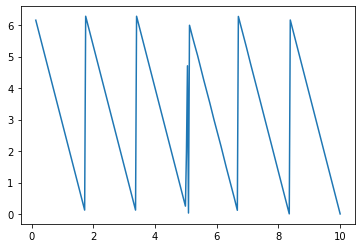

In [8]:
plt.plot(t_list, a_list)